[View in Colaboratory](https://colab.research.google.com/github/aashish2894/quick-draw-classifier/blob/master/quick_draw_classifier.ipynb)

Quick-Draw-Classifier

This classifies 100 classes

In [4]:
!wget 'https://raw.githubusercontent.com/aashish2894/quick-draw-classifier/master/mini_classes.txt'


Redirecting output to ‘wget-log’.


In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [10]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [17]:
print(len(x_train))

400000


traffic_light


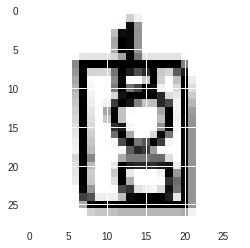

In [20]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [36]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
__________

In [41]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 64, verbose=2, epochs=7)

Train on 360000 samples, validate on 40000 samples
Epoch 1/7
 - 75s - loss: 0.5147 - top_k_categorical_accuracy: 0.9659 - val_loss: 0.7849 - val_top_k_categorical_accuracy: 0.9404
Epoch 2/7
 - 75s - loss: 0.5066 - top_k_categorical_accuracy: 0.9667 - val_loss: 0.7806 - val_top_k_categorical_accuracy: 0.9418
Epoch 3/7
 - 75s - loss: 0.4978 - top_k_categorical_accuracy: 0.9676 - val_loss: 0.8042 - val_top_k_categorical_accuracy: 0.9403
Epoch 4/7
 - 75s - loss: 0.4901 - top_k_categorical_accuracy: 0.9681 - val_loss: 0.7888 - val_top_k_categorical_accuracy: 0.9403
Epoch 5/7
 - 75s - loss: 0.4830 - top_k_categorical_accuracy: 0.9695 - val_loss: 0.8019 - val_top_k_categorical_accuracy: 0.9398
Epoch 6/7
 - 75s - loss: 0.4741 - top_k_categorical_accuracy: 0.9700 - val_loss: 0.8028 - val_top_k_categorical_accuracy: 0.9387
Epoch 7/7
 - 75s - loss: 0.4662 - top_k_categorical_accuracy: 0.9709 - val_loss: 0.8246 - val_top_k_categorical_accuracy: 0.9389


In [42]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.82%


['door', 'cell_phone', 'book', 'bread', 'diving_board']


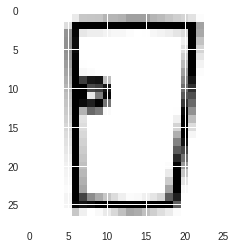

In [44]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [46]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 13.9MB 2.5MB/s 
    100% |████████████████████████████████| 58.4MB 885kB/s 
    100% |████████████████████████████████| 307kB 12.9MB/s 
    100% |████████████████████████████████| 51kB 9.6MB/s 
tensorflow 1.10.1 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.1 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: tensorflow 1.11.0rc2
    Uninstalling tensorflow-1.11.0rc2:
      Successfully uninstalled tensorflow-1.11.0rc2
  Found existing installation: Keras-Applications 1.0.5
    Uninstalling Keras-Applications-1.0.5:
      Successfully uninstalled Keras-Applications-1.0.5
  Found existing installation: Keras-Preprocessing 1.0.3
    Uninstalling Keras-Preprocessing-1.0.3:
      Successfully uninstalled Keras-Preprocessing-1.0.3
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
    

In [47]:
model.save('keras.h5')

In [48]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

Using TensorFlow backend.


In [0]:
!cp class_names.txt model/class_names.txt

In [50]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 90%)
  adding: model/group1-shard1of1 (deflated 7%)
  adding: model/class_names.txt (deflated 41%)


In [0]:
from google.colab import files
files.download('model.zip')